In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:

data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';') #data para kmeans
data2= pd.read_csv("./Barcelona_rent_price.csv", delimiter=';') #data para reemplazo por media

In [4]:
#iniciamos con el modelo eliminacion outliers con kmeans /clusters 
# Selección de columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])


In [5]:
# Escalar los datos cluster 
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

In [7]:
# Aplicar K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# Añadir los clusters al dataframe original
data['Cluster'] = clusters

In [9]:
# Calcular la distancia de cada punto al centroide del clúster
data['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)

In [10]:
# Definir umbral para considerar un punto como outlier 
threshold = data['Distance_to_Centroid'].quantile(0.95)

In [11]:
# Identificar outliers
data['Is_Outlier'] = data['Distance_to_Centroid'] > threshold

In [12]:
# Eliminar outliers antes de continuar con el modelado clusters
data_clean = data[~data['Is_Outlier']]

In [13]:
# en este apartado diferenciamos el dataframe para modelaje de kmeans
data_kmeans= pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])

a continuacion realizaremos el mismo procedimiento para outliers reemplazados por la mediana, utilizaremos el df= data2

In [14]:
#rango intercuartilico para identificacion outliers
Q1 = data2['Price (euro/m2)'].quantile(0.25)
Q3 = data2['Price (euro/m2)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [15]:
#Corrección o imputación de outliers
#Reemplazamos los outliers con la mediana para mantener la integridad de los datos:
median_value = data2['Price (euro/m2)'].median()
data2['Price (euro/m2)'] = data2['Price (euro/m2)'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)


In [16]:
# Seleccionamos solo las columnas numéricas del DataFrame
numeric_data2 = data2.select_dtypes(include=['float64', 'int64'])

In [17]:
data_media = pd.get_dummies(data2, columns=['District', 'Neighbourhood'])

ya tenemos los resultados de la gestion y correccion de outliers para cada modelo
almacenados en dos dataframes diferentes , y procedemos a evaluacion de cada modelo

data_kmeans= pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])
data_media = pd.get_dummies(data2, columns=['District', 'Neighbourhood'])


In [18]:
# Preparar los datos para el modelo con outliers reemplazados por la media
X_media = data_media.drop('Price (euro/m2)', axis=1)
y_media = data_media['Price (euro/m2)']

In [49]:
#División Train Test
#Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba:
X_train_media, X_test_media, y_train_media, y_test_media = train_test_split(X_media, y_media, test_size=0.2, random_state=42)

In [50]:
#escalado de datos para modelos de median 
scaler_media = MinMaxScaler()
X_train_scaled_media = scaler_media.fit_transform(X_train_media)
X_test_scaled_media = scaler_media.transform(X_test_media)

In [21]:
# Entrenar el modelo de regresión lineal para median
model_media = LinearRegression()
model_media.fit(X_train_scaled_media, y_train_media)

LinearRegression()

In [23]:
# Predicciones y evaluacion del modelo median
y_pred_media = model_media.predict(X_test_scaled_media)
# Métricas de evaluación
mae_media = mean_absolute_error(y_test_media, y_pred_media)
mse_media = mean_squared_error(y_test_media, y_pred_media)
rmse_media = np.sqrt(mse_media)
r2_media = r2_score(y_test_media, y_pred_media)

print("\nModelo con outliers reemplazados por la mediana:")
print(f"MAE: {mae_media}, MSE: {mse_media}, RMSE: {rmse_media}, R²: {r2_media}")


Modelo con outliers reemplazados por la mediana:
MAE: 0.5674745207883369, MSE: 0.7946401135570287, RMSE: 0.891425887865631, R²: 0.845140009223655


In [54]:
# Validación cruzada para reeemplazo de outliers por mediana
scores_media = cross_val_score(model_media, X_media, y_media, cv=5, scoring='r2')
print("Validación cruzada R² (media):", scores_media.mean(), scores_media.std())

Validación cruzada R² (media): -190283142484507.56 380566284969016.6


Ahora procederemos a la evaluacion del modelo de outliers gestionados por clusters:

In [26]:
# Preparar los datos para el modelo con outliers eliminados usando K-means
X_kmeans = data_kmeans.drop('Price (euro/m2)', axis=1)
y_kmeans = data_kmeans['Price (euro/m2)']

In [27]:

X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = train_test_split(X_kmeans, y_kmeans, test_size=0.2, random_state=42)

scaler_kmeans = MinMaxScaler()
X_train_scaled_kmeans = scaler_kmeans.fit_transform(X_train_kmeans)
X_test_scaled_kmeans = scaler_kmeans.transform(X_test_kmeans)

In [28]:
# Entrenar el modelo de regresión lineal para clusters
model_kmeans = LinearRegression()
model_kmeans.fit(X_train_scaled_kmeans, y_train_kmeans)

LinearRegression()

In [30]:
# Predicciones del modelo CLUSTERS
y_pred_kmeans = model_kmeans.predict(X_test_scaled_kmeans)

# Métricas de evaluación
mae_kmeans = mean_absolute_error(y_test_kmeans, y_pred_kmeans)
mse_kmeans = mean_squared_error(y_test_kmeans, y_pred_kmeans)
rmse_kmeans = np.sqrt(mse_kmeans)
r2_kmeans = r2_score(y_test_kmeans, y_pred_kmeans)
print("\nModelo con outliers eliminados por K-means:")
print(f"MAE: {mae_kmeans}, MSE: {mse_kmeans}, RMSE: {rmse_kmeans}, R²: {r2_kmeans}")


Modelo con outliers eliminados por K-means:
MAE: 0.4670750284738041, MSE: 0.4448386491136833, RMSE: 0.6669622546394086, R²: 0.914783518757025


In [53]:
# Validación cruzada k-means
scores_kmeans = cross_val_score(model_kmeans, X_kmeans, y_kmeans, cv=5, scoring='r2')
print("Validación cruzada R² (K-means):", scores_kmeans.mean(), scores_kmeans.std())

Validación cruzada R² (K-means): 0.7505087962948618 0.15414599591197237


COMPARACION DE RESULTADOS DE LOS DOS MODELOS (MEDIAN VS KMEANS )

In [32]:
# Comparar las métricas de ambos modelos
print("\nComparación de Modelos")
print("Modelo con outliers reemplazados por la mediana:")
print(f"MAE: {mae_media}, MSE: {mse_media}, RMSE: {rmse_media}, R²: {r2_media}")
print("Validación cruzada R² (media):", scores_media.mean(), scores_media.std())

print("\nModelo con outliers eliminados por K-means:")
print(f"MAE: {mae_kmeans}, MSE: {mse_kmeans}, RMSE: {rmse_kmeans}, R²: {r2_kmeans}")
print("Validación cruzada R² (K-means):", scores_kmeans.mean(), scores_kmeans.std())



Comparación de Modelos
Modelo con outliers reemplazados por la mediana:
MAE: 0.5674745207883369, MSE: 0.7946401135570287, RMSE: 0.891425887865631, R²: 0.845140009223655
Validación cruzada R² (media): -77619028099098.77 232857084297298.6

Modelo con outliers eliminados por K-means:
MAE: 0.4670750284738041, MSE: 0.4448386491136833, RMSE: 0.6669622546394086, R²: 0.914783518757025
Validación cruzada R² (K-means): -6141762183469.651 18425286550411.492


In [33]:
#Analisis de residuales
# Obtener los residuales para el modelo con outliers reemplazados por la media
residuals_media = y_test_media - y_pred_media

# Obtener los residuales para el modelo con outliers eliminados por K-means
residuals_kmeans = y_test_kmeans - y_pred_kmeans

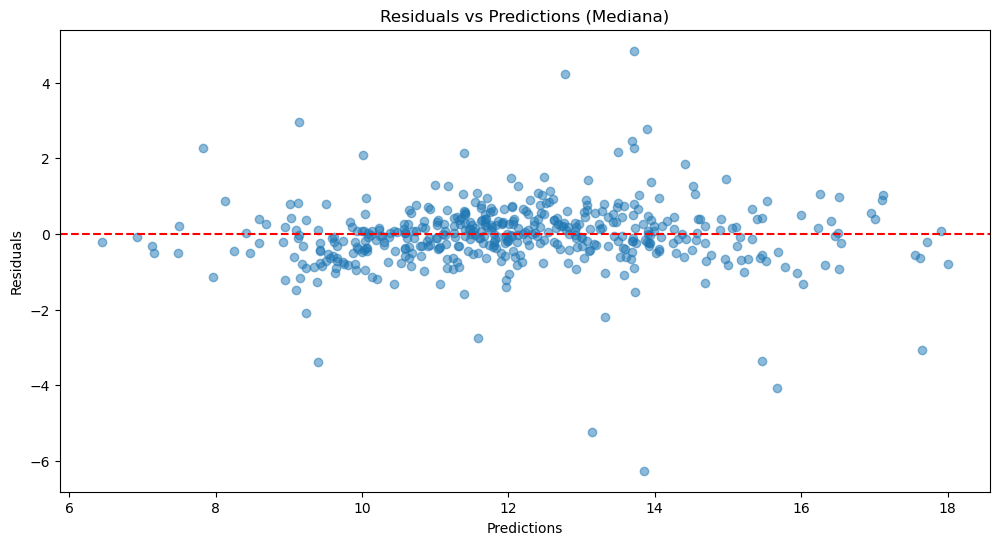

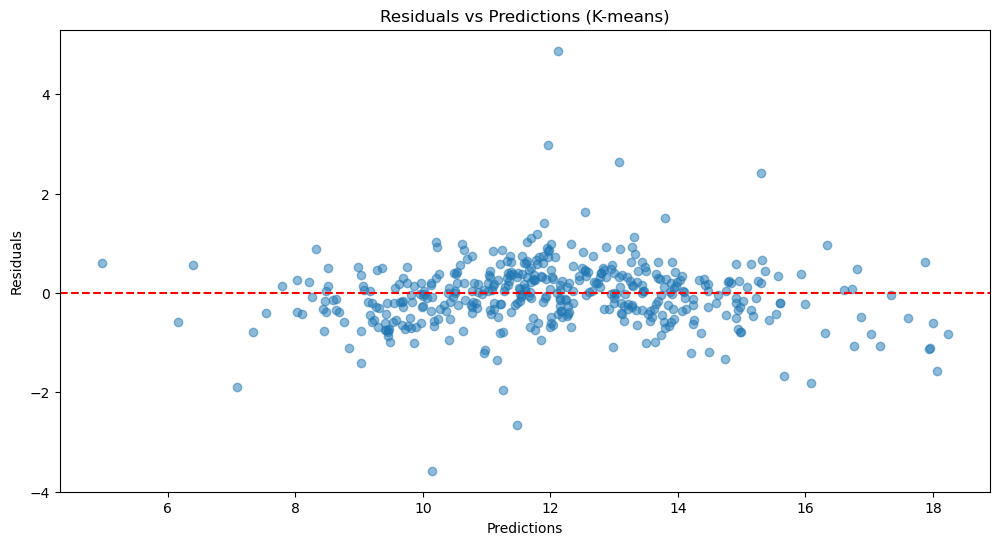

In [34]:
# Residuales vs. Predicciones (Media)
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_media, residuals_media, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions (Mediana)")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.show()

# Residuales vs. Predicciones (K-means)
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_kmeans, residuals_kmeans, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions (K-means)")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


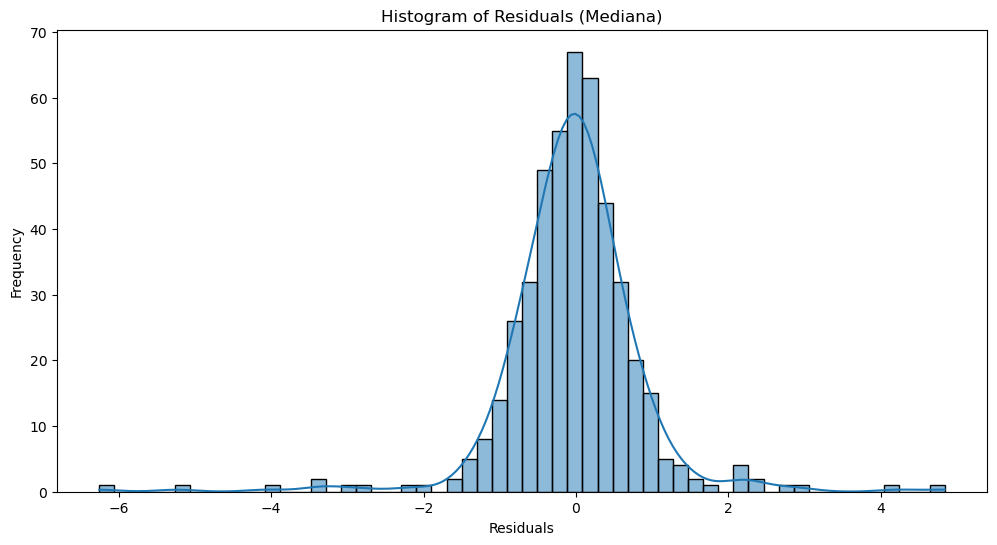

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


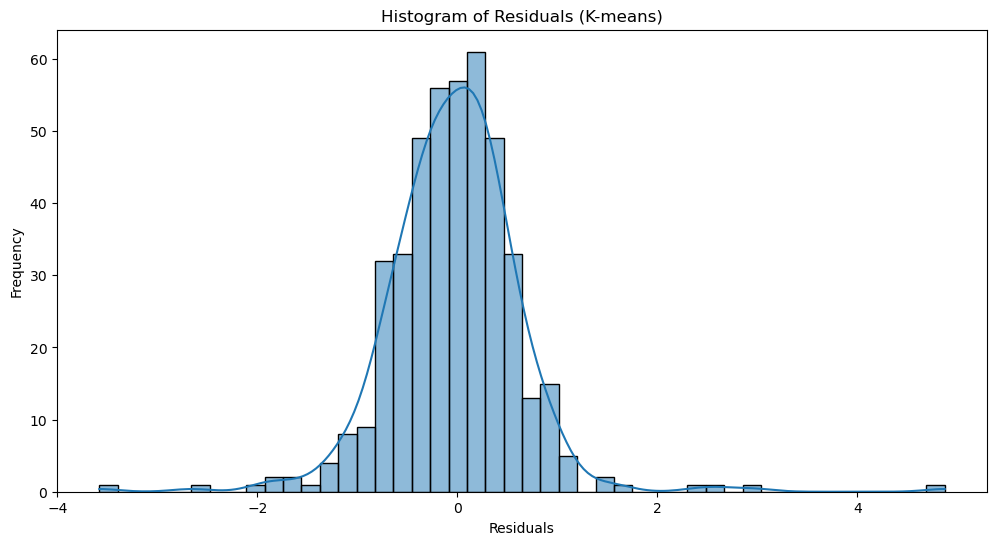

In [37]:
#Histograma de los Residuales
# Histograma de Residuales (Mediana)
plt.figure(figsize=(12, 6))
sns.histplot(residuals_media, kde=True)
plt.title("Histogram of Residuals (Mediana)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Histograma de Residuales (K-means)
plt.figure(figsize=(12, 6))
sns.histplot(residuals_kmeans, kde=True)
plt.title("Histogram of Residuals (K-means)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

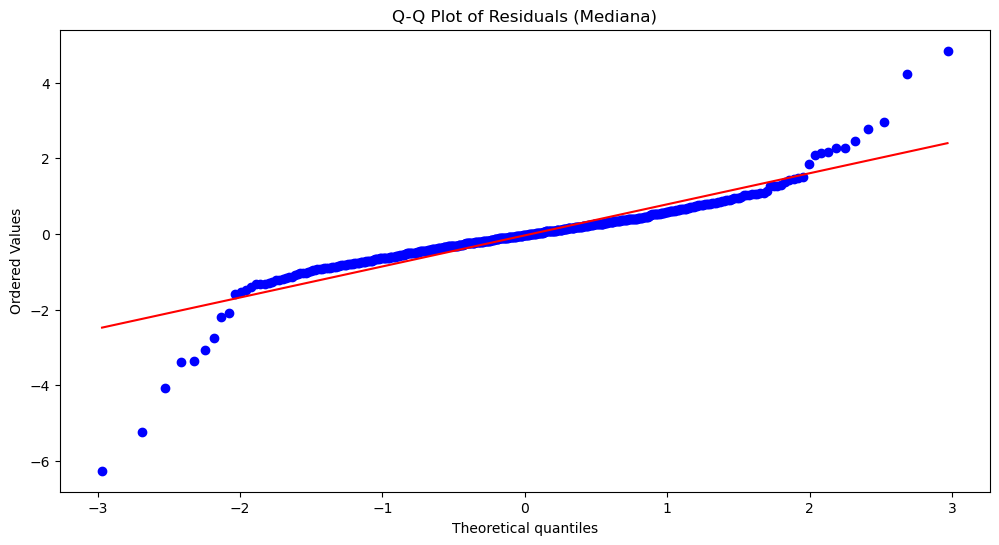

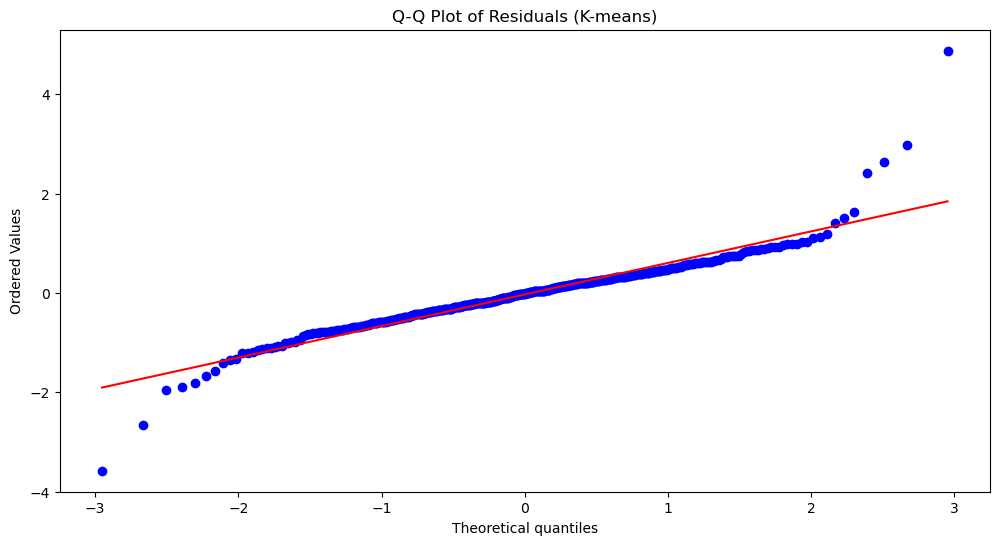

In [39]:

# Q-Q Plot de Residuales (Mediana)
plt.figure(figsize=(12, 6))
stats.probplot(residuals_media, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Mediana)")
plt.show()

# Q-Q Plot de Residuales (K-means)
plt.figure(figsize=(12, 6))
stats.probplot(residuals_kmeans, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (K-means)")
plt.show()